### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [56]:
# PCA source: Week 2 slides - Manifold Learning

import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
# l = data['l'].flatten()  # image Labels (1,520)

# Does a 8/2 split of dataset (8 images / 2 images of each person). Training data shuffled. 
def Q1_partition(data):
    X = data['X'] # flat images dim (2576,520)
    X_train, X_test = [], []
    for i in range(0, 520, 10):
        im_train, im_test = train_test_split(X[:, i: i + 10].T, test_size=0.2, random_state=42)
        X_train.append(im_train)    
        X_test.append(im_test)  
  
    return  np.array(X_train).reshape(-1, 2576), np.array(X_test).reshape(-1, 2576)

In [60]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()
    # display_image(X_train[1:2].T, "hey")
    # display_image(t1[i:i+1].T, "Hey")

def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

# S = Covariance Matrix, A = mean centred data, N = #samples
def PCA(batch, threshold = 0.95):
    _, mean, S = process_batch(batch)
    eigenvalues, eigenvectors = get_sorted_eigen(S)
    k = choose_principal_components(threshold, eigenvalues)
    return eigenvalues[:k + 1], eigenvectors[:, :k + 1], mean

def choose_principal_components(threshold, eigenvalues):
    covariance_ratios = eigenvalues/np.sum(eigenvalues)
    cum_var = 0
    for k, ratio in enumerate(covariance_ratios):
        cum_var += ratio
        if cum_var >= threshold: return k 

def process_batch(batch):
    mean = np.mean(batch, axis=0)
    A = batch - mean
    print(f'batch: {batch.shape}')
    print(f'A: {A.shape}')
    N = A.shape[1]
    S = (1/N) * np.dot(A.T, A)
    print(f'S: {S.shape}')
    print(f'Mean: {mean.shape}')
    return N, mean, S

In [79]:
# They cannot possibly be the same since they have different dimensions. 
X_train, X_test = Q1_partition(data)
##### Look here FELIX - AAT: S = (1/N) A * A^T, ATA: S = (1/N) A^T * A  
eigenvalues_AAT, eigenvectors_AAT, mean1 = PCA(X_train)
eigenvalues_ATA, eigenvectors_ATA, mean2 = PCA(X_train.T)
##########

batch: (416, 2576)
A: (416, 2576)
S: (2576, 2576)
Mean: (2576,)
batch: (2576, 416)
A: (2576, 416)
S: (416, 416)
Mean: (416,)


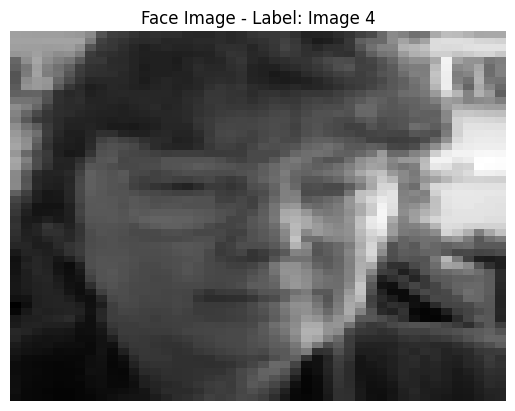

(2576,) (120,) (2576, 120)


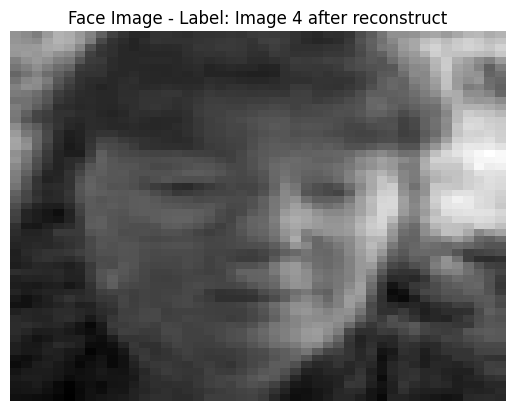

In [98]:
def deconstruct(image, eigenvects, mean):
    reduced = image - mean
    projected = np.zeros((eigenvects.shape[1]))
    for i, vector in enumerate(eigenvects.T) :
        projected[i] = np.dot(reduced, vector)
    return projected


def reconstruct(projected, eigenvects, mean) :
    image = mean.copy()
    print(image.shape, projected.shape, eigenvects.shape)
 #   for i, vector in enumerate(eigenvects) :
 #       image += projected[i] * vector
        
    image = mean + np.sum((eigenvects * projected), axis=1)
    return image


test_image = X[:, 4]
display_image(test_image, "Image 4")
projected = deconstruct(test_image, eigenvectors_AAT, mean1)
re_image = reconstruct(projected, eigenvectors_AAT, mean1)

display_image(re_image, "Image 4 after reconstruct")

In [137]:
def testing_NN(image, projections, eigenvects, mean) :
    projected = deconstruct(image, eigenvects, mean)
    print(np.linalg.norm((projections - projected), axis=1))
    print(projections.shape)
    return np.argmin(np.linalg.norm((projections - projected), axis=1))

def fulltest(X_test, X_train, eigenvects, mean):
    projections = np.array([deconstruct(X_train[i], eigenvects, mean) for i in range(len(X_train))])
    res = []
    for i, image in enumerate(X_test):
        res.append(testing_NN(X_test[i], projections, eigenvectors_AAT, mean1) % 8 + 1)
    return res
    
projections = np.array([deconstruct(X_train[i], eigenvectors_AAT, mean1) for i in range(len(X_train))])

res = testing_NN(X_train[6], projections, eigenvectors_AAT, mean1)
print(res)

res = fulltest(X_test, X_train, eigenvectors_AAT, mean1)
print(res)

[1131.04000785 2239.41673368 2220.64204379 1145.22433195 2570.32385665
 1591.51364715    0.         2842.87803194 3160.85514807 3629.78515583
 2851.78542907 3090.15027507 2653.83838195 2781.82539907 2953.55902998
 2663.14687632 1711.63142123 2116.80525501 2139.70332378 1845.36253772
 1941.3632529  2181.34653927 1572.01784482 2087.04936693 1975.15997013
 2457.14914199 3043.30271238 2525.1704853  3054.69952768 2347.68874955
 2093.33279354 2767.64349282 2880.7284798  2487.41262178 2342.92496865
 3077.59611299 2484.84084006 2588.18845619 2412.650712   2375.81224651
 2465.59940871 2765.5226245  2571.51788616 1913.66601796 2715.73839211
 2515.61528796 1947.49061518 3214.2795737  1880.15457898 2751.2805763
 2587.68595465 2591.14796755 2607.03812244 2493.76498175 1505.10309249
 2776.18894943 2167.36273251 3149.52975468 2323.31954018 2459.27555534
 2248.54920931 2032.09636542 2231.87564685 2485.03463208 3342.4706584
 2547.15331564 2806.76718805 3277.10365782 2386.19407687 3769.98946715
 3305.60